In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from statsmodels.graphics.gofplots import ProbPlot


## Helper functions!

In [3]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [4]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [5]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_temp['Downtown_NotWeekday_Center'] = X['Downtown'] * (1 - X['Weekday'] ) * X['Center']
X_temp["Shops_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['Shops'] 

In [6]:
X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,0,0,974,10,1,1,0,0
2,0,0,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,0,0,958,9,1,1,0,1
4,0,0,0,0,0,0,0,103,4,0,1,0,1


## Pre Process the data

This is an optional step so we can see the base line model results. We can examine the p variables to determine which variables should be excluded.

In [7]:
# Preprocess the data
# 1. Separate the data into training and test data
# 2. Fit the scaling to the training data and apply to both the train and test data 

# Define columns to scale
columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops', 'Shops_DWC', 'Shops_DT']

# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X_new,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# 2. Scale
scaler = StandardScaler().fit(train[columns_to_scale]) 

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

train.head()


,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
7214,71.451101,0.629417,0.807052,1,1,1,0,-0.145495,0.627193,0.830934,1,1,1,1
13522,64.949936,0.546223,0.397534,1,0,0,0,-0.145495,0.534761,0.286455,1,1,0,0
18479,70.265111,0.640364,0.192776,1,0,1,0,-0.145495,0.639356,0.014215,1,1,0,1
3366,70.693183,0.655689,0.602293,1,0,1,0,-0.145495,0.656382,0.558694,1,1,0,1
21645,16.757929,-1.540207,-1.445294,0,0,0,0,-0.145495,-1.508474,-1.346982,0,1,0,0


In [8]:
# Build and execute model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High" 
model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.2689971805073357
Train MSE:  0.2716177647625184


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.062e+06
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        08:55:04   Log-Likelihood:                -13504.
No. Observations:               17600   AIC:                         2.703e+04
Df Residuals:                   17589   BIC:                         2.712e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      89.2922      0.192    465.375      0.000      88.916      89.668
Shops_DT       41.8493      0.660     63.424      0.000      40.556      43.143
Weekday__DT     0.2245      0.019     11.644      0.000       0.187       0.262
Center_DT      -0.5775      0.030    -19.168      0.000      -0.637      -0.518
Shops_DWC       2.8462      0.005    583.520      0.000       2.837       2.856
Shops           7.6029      0.586     12.969      0.000       6.454       8.752
ATMs           -3.6752      0.008   -455.001      0.000      -3.691      -3.659
Downtown      -47.8967      0.272   -175.809      0.000     -48.431     -47.363
Weekday        -2.2178      0.016   -140.071      0.000      -2.249      -2.187
Center          3.5912      0.024    150.664      0.000       3.545       3.638
High            1.0020      0.009    116.833      0.000       0.985       1.019
==============================================================================
Omnibus:                       64.483   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.312
Skew:                           0.113   Prob(JB):                     5.39e-16
Kurtosis:                       3.212   Cond. No.                         426.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Doing some manual cross validation checking to assess if doing cross validation is necessary. From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 

I guess the shops x dt x c x w makes sense bc its the same as having dt x c x w but with more granularity to it. This model prioritises interpretability.

## Diagnostic Plots (Plotting the residuals)

In [13]:
# model values
model_fitted_y = model.fittedvalues

# model residuals
model_residuals = model.resid

# normalized residuals 
model_norm_residuals = model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

test_predictions = model.predict(test)  # Assuming test has the feature columns

Text(0, 0.5, 'Residuals')

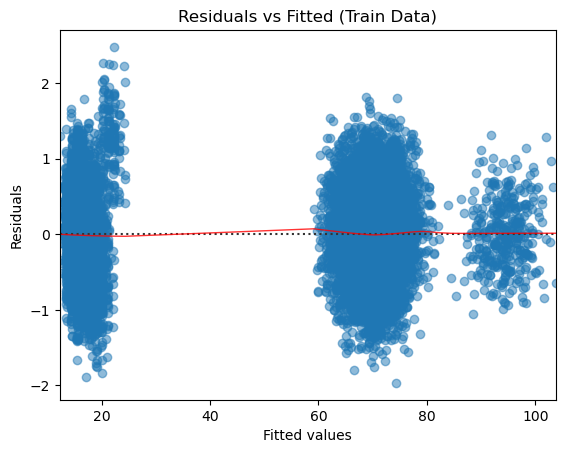

In [14]:
plot_lm = plt.figure()
plot_lm.axes[0] = sns.residplot(x=model_fitted_y, 
                               y='Withdraw',
                               data=train,
                               lowess=True,
                               scatter_kws={'alpha': 0.5},
                               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm.axes[0].set_title('Residuals vs Fitted (Train Data)')
plot_lm.axes[0].set_xlabel('Fitted values')
plot_lm.axes[0].set_ylabel('Residuals') 

Text(0, 0.5, 'Residuals')

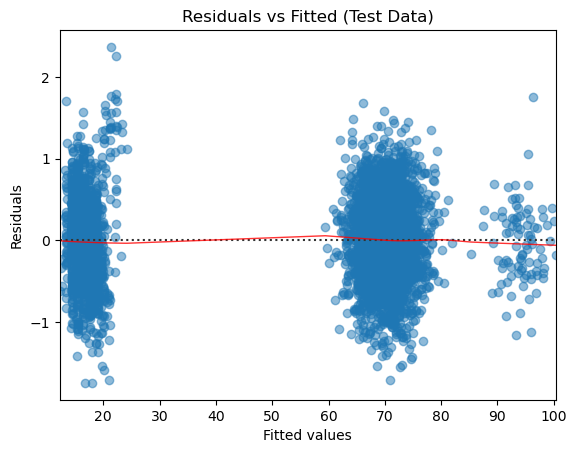

In [16]:
plot_lm = plt.figure()
plot_lm.axes[0] = sns.residplot(x=test_predictions, 
                               y='Withdraw',
                               data=test,
                               lowess=True,
                               scatter_kws={'alpha': 0.5},
                               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm.axes[0].set_title('Residuals vs Fitted (Test Data)')
plot_lm.axes[0].set_xlabel('Fitted values')
plot_lm.axes[0].set_ylabel('Residuals') 

c:\Users\eReuse\anaconda3\Lib\site-packages\statsmodels\graphics\gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


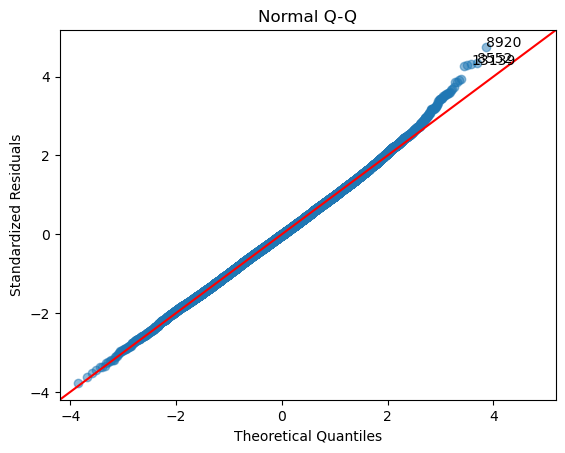

In [19]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));